In [25]:
library(tidyverse)
library(qusage)
library(destiny)
library(princurve)
library(scatterplot3d)
library(slingshot)
library(viridis)
library(BiocParallel)
library(grid)
library(gplots)
library(SingleCellExperiment)
library(Seurat)
library(DelayedMatrixStats)
library(Cairo)
library(reshape2)
library(VennDiagram)

Loading required package: futile.logger



In [2]:
CairoFonts(
  regular="FreeSans:style=Medium",
  bold="FreeSans:style=Bold",
  italic="FreeSans:style=Oblique",
  bolditalic="FreeSans:style=BoldOblique"
)


In [3]:
## load data
pc.filt.combined = readRDS("BMPC_SeuratObj.rds")

In [4]:
## Load DEG and GeneSet annotation data
load("./BMPC_atlas/data/MAST_DEG.RData")
load("./BMPC_atlas/data/Annotation_GeneSet_List.RData")

### Figure 3B
The source data is provided as supplementary Table 4 & 5 

In [8]:
tnfa = read.csv("./BMPC_atlas/data/6vs7.GseaPreranked/HALLMARK_TNFA_SIGNALING_VIA_NFKB.csv",header = T,row.names = 1)
## This table corresponds to Supplementary Table 5
tnfa.lead = tnfa$PROBE[tnfa$CORE.ENRICHMENT=="Yes"]
pc.fig3 = subset(pc.filt.combined,idents = c(5,6,7))
tnfa.data = pc.fig3[["RNA"]]@data[tnfa.lead,]
tnfa.data = t(tnfa.data)
tnfa.data = as.data.frame(as.matrix(tnfa.data))
tnfa.data$cluster_id = pc.fig3$cluster_id
tnfa4plot = melt(tnfa.data,id = "cluster_id")


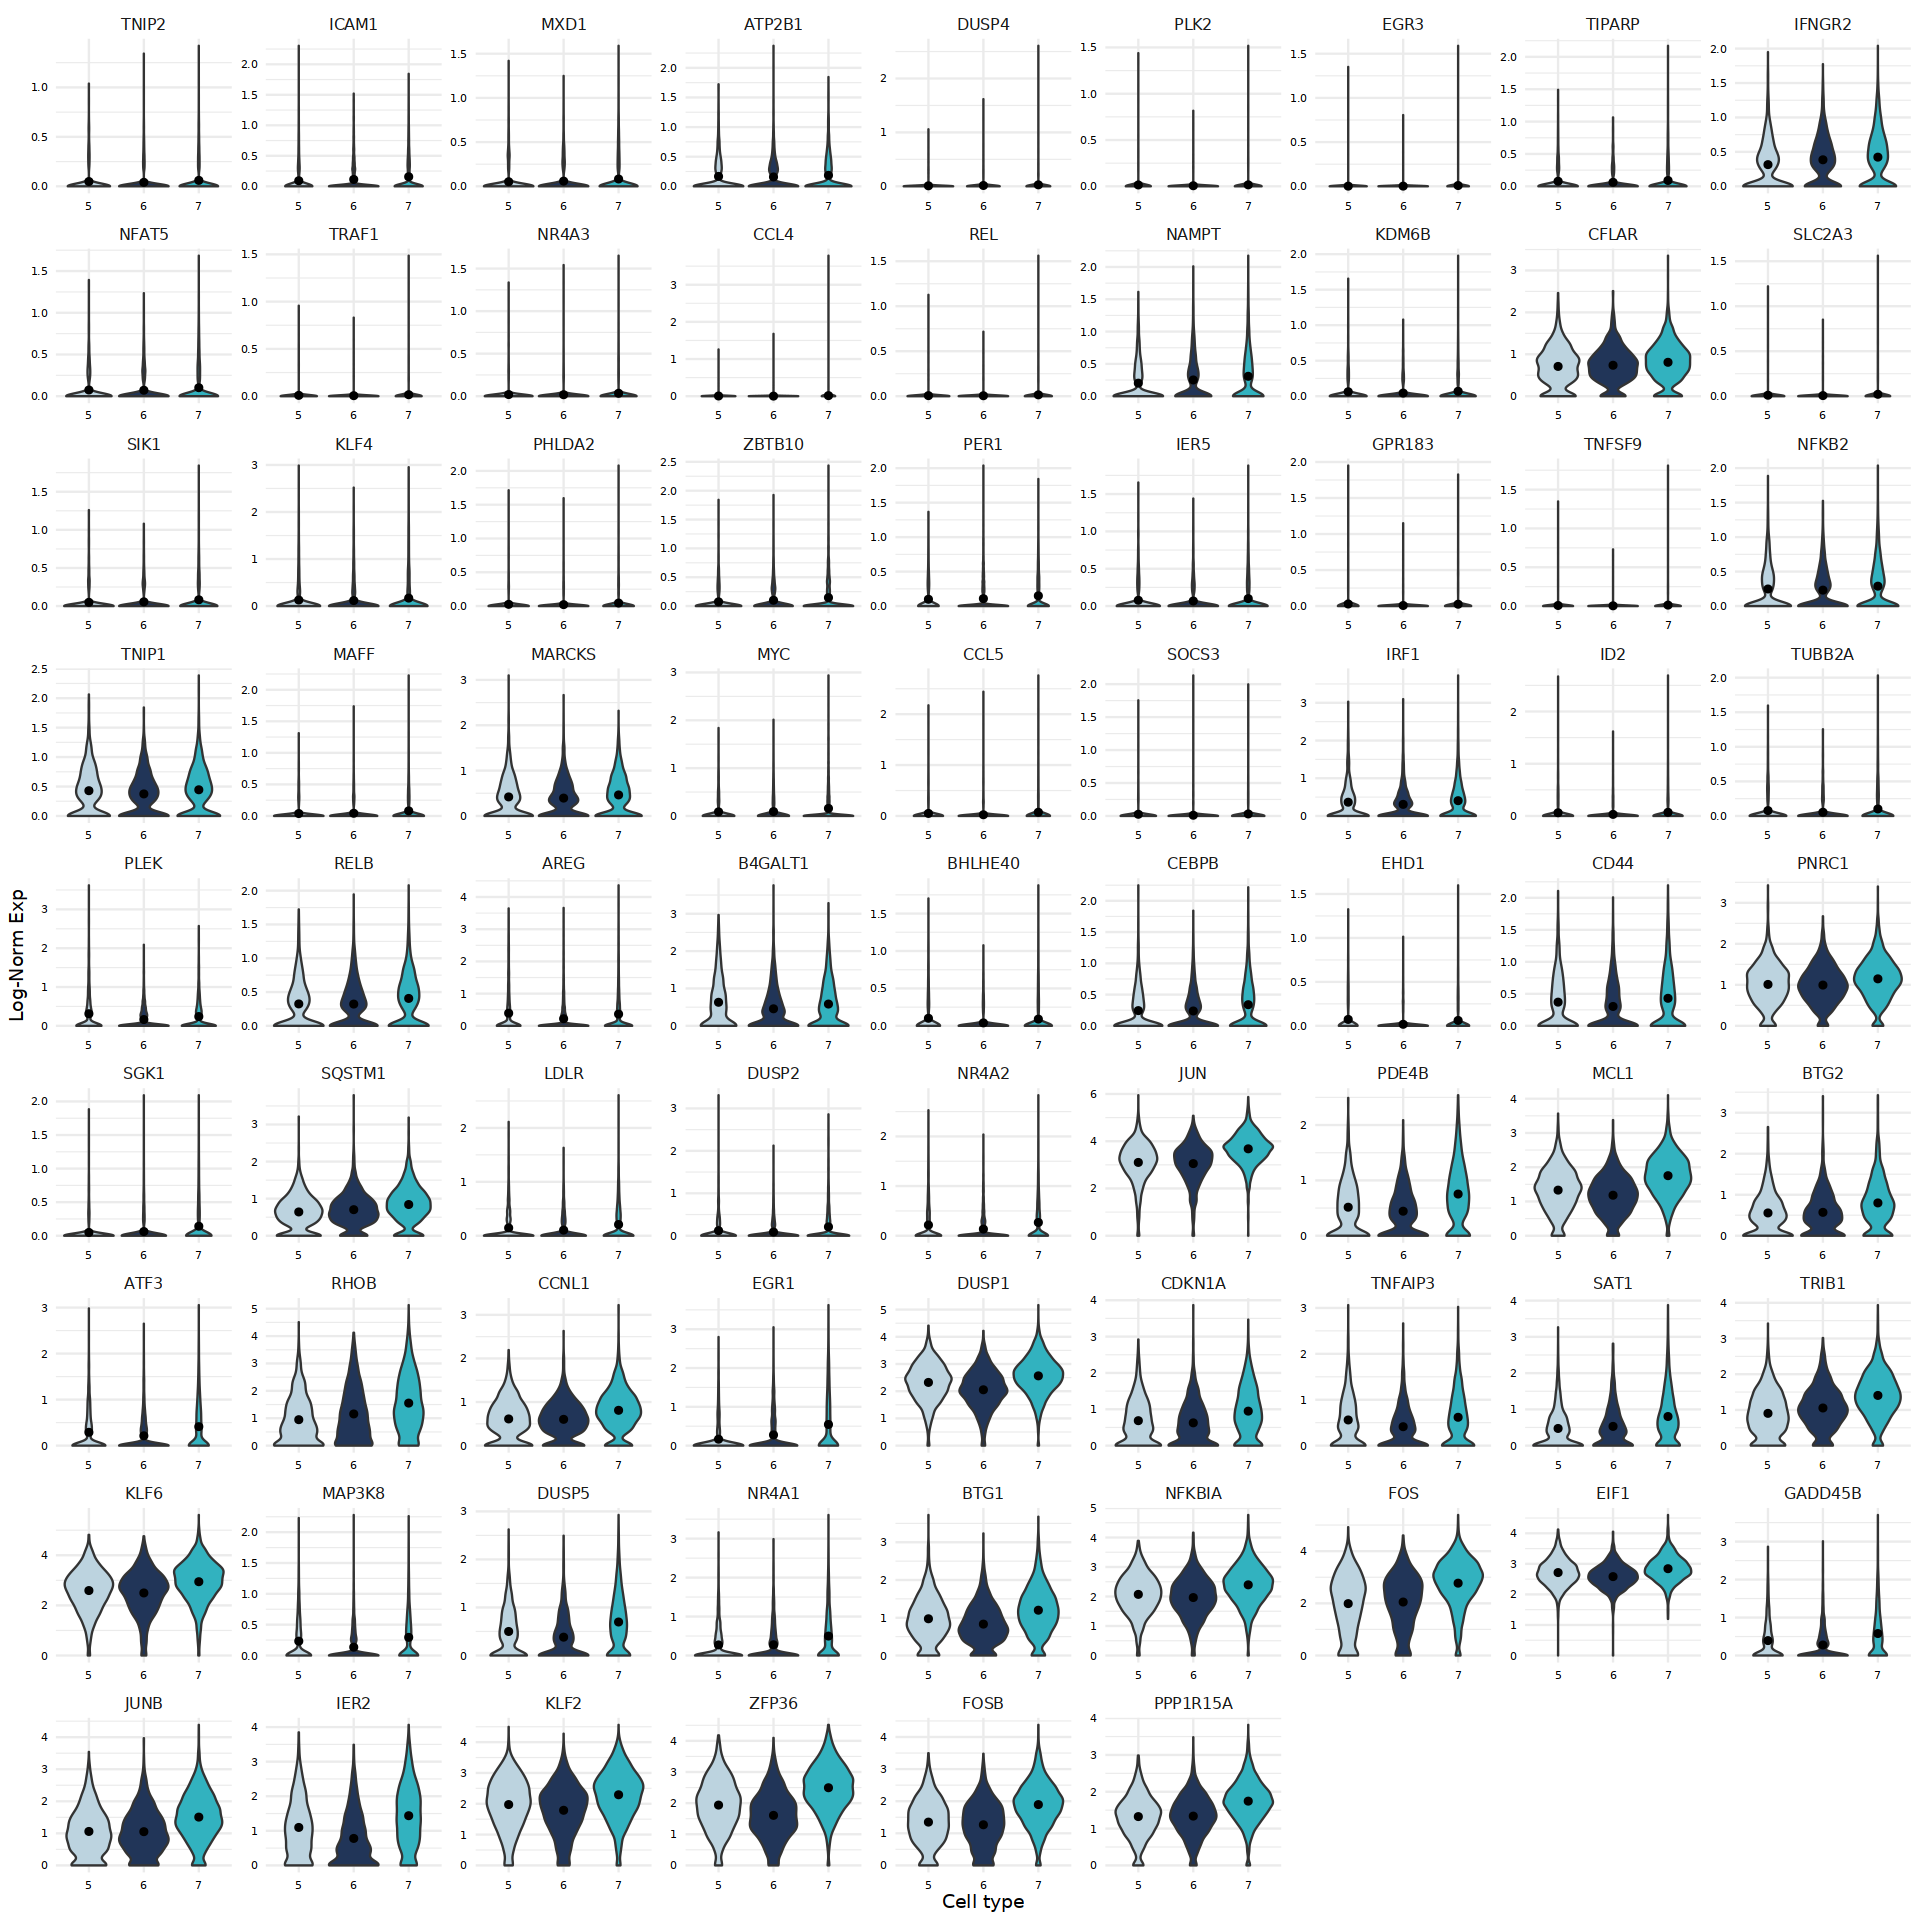

In [10]:
## Figure S6C
options(repr.plot.width=16, repr.plot.height=16)
ggplot(tnfa4plot,aes(x = factor(cluster_id),y = value,group = cluster_id,fill = cluster_id)) + 
  geom_violin()+scale_fill_manual(values = c("#BCD3DF", "#213558", "#32B2BF","#5ABC6C","#428C53","#143E2A"))+
  #geom_point(size = 0.8,alpha = 0.8) +  #, shape=Status,)
  facet_wrap(.~variable,scales = "free",ncol = 9) +#,
  stat_summary(fun = "mean",
               geom = "point",
               color = "black")+
  #geom_line()+
  #geom_smooth(method = "loess",span = 0.6,se = FALSE,size = 0.75)+ #,color =c("#40C5E7","#3EAB49","#552E8C","#552E8C" )
  labs(x = "Cell type", y = "Log-Norm Exp") +
  theme_minimal()+
  theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,colour="black", size = 6),
        axis.text.y = element_text(colour = "black",size = 6),
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9),legend.position = "none")

#### load DEGs by comparing cluster 5 vs 6 and 5 vs 7, these are DEGs associated with the bifurcation of late BMPC maturation

In [11]:
late567 =  read.csv("./BMPC_atlas/data/Supplementary_Table4.csv",header = T)
temp = melt(late567,id = 0)
#temp = subset(temp,! variable %in% c("X5vs6.up.5vs7.up","X5vs6.down.5vs7.down"))
temp = unique(temp$value)

## the leading DEGs enriched in TNFa signaling via NKFB pathway
de.tnfa.lead = intersect(tnfa.lead,temp)

## loading DEGs by directly comparing cluster 6 and cluster 7 
load("./BMPC_atlas/data/HD_6vs7_MAST_Subject.RData")
deg67 = subset(deg.res1,p_val_adj <0.05 & abs(avg_logFC)>=0.25)

In [15]:
## Combined all the DEGs associated with BMPC maturation but getting rid of proliferative cell related DEGs 
deg.union1 = c()
for(i in names(mast.deg)[-c(4,5)]){
  deg.union1 = union(deg.union1,row.names(mast.deg[[i]]))
}

In [16]:
## Pathway enrichment score by individual and cell cluster
Hindex = which(grepl("^HALLMARK_",names(GeneSet)))
Have.ind = matrix(0,nrow = length(Hindex),ncol = 15*5) # 15 cell clusters * 5 donors
row.names(Have.ind) = names(GeneSet)[Hindex]
colnames(Have.ind) = paste0(rep(levels(pc.filt.combined$cluster_id),each = 5),"-",levels(pc.filt.combined$Donor))

geneset.selected = names(GeneSet)[Hindex]
for(j in geneset.selected) {
  print(j)
  
  temp = intersect(deg.union1,GeneSet[[j]])
  
  #filter for GSEA genes
  if(length(temp)>1){
    score = pc.filt.combined[["RNA"]]@data[which(row.names(pc.filt.combined[["RNA"]]@data) %in% temp),]
    score = as.matrix(score)
    score.mean = as.data.frame(colMeans(score))
    score.mean$cluster_id = pc.filt.combined$cluster_id
    score.mean$Donor = pc.filt.combined$Donor
    score.mean$cluster_Donor = paste0(score.mean$cluster_id,"-",score.mean$Donor)
    names(score.mean) = c("Mean","cluster_id","Donor","Celltype")
    score.mean$Celltype = factor(score.mean$Celltype,levels = paste0(rep(levels(pc.filt.combined$cluster_id),each = 5),"-",levels(pc.filt.combined$Donor)))
    cluster_id.mean = aggregate(Mean ~ Celltype,data = score.mean,FUN = mean)
    Have.ind[j,] = t(cluster_id.mean$Mean)
    color_by = score.mean$Mean
  }
}

de.tnfa.lead = union(de.tnfa.lead,intersect(tnfa.lead,row.names(deg67)))
tnfa.lead.exp = as.matrix(pc.filt.combined[["RNA"]]@data[de.tnfa.lead,])
tnfa.lead.exp = t(tnfa.lead.exp)
tnfa.lead.exp = as.data.frame(tnfa.lead.exp)
# tnfa.lead.exp$cluster_id = pc.filt.combined$cluster_id
# tnfa.lead.exp$Donor = pc.filt.combined$Donor
tnfa.lead.exp$cluster_Donor = paste0(pc.filt.combined$cluster_id,"-",pc.filt.combined$Donor)
tnfa.lead.exp$cluster_Donor = factor(tnfa.lead.exp$cluster_Donor,levels = paste0(rep(levels(pc.filt.combined$cluster_id),each = 5),"-",levels(pc.filt.combined$Donor)))
tnfa.lead.exp.mean = apply(tnfa.lead.exp[,1:34],2,function(x) aggregate(x ~ cluster_Donor,data = tnfa.lead.exp,FUN = mean))
names(tnfa.lead.exp.mean) = names(tnfa.lead.exp)[1:34]
tnfa.mean = do.call(cbind,tnfa.lead.exp.mean)
tnfa.mean = tnfa.mean[,c(1,seq(2,68,2))]
names(tnfa.mean) = c("cluster_Donor",names(tnfa.lead.exp)[1:34])
tnfa.mean$ES = Have.ind["HALLMARK_TNFA_SIGNALING_VIA_NFKB",]
tnfa.mean = t(tnfa.mean)
tnfa.mean = as.data.frame(tnfa.mean)
names(tnfa.mean) = as.matrix(tnfa.mean[1,])
tnfa.mean = tnfa.mean[-1,]
fig4c = tnfa.mean[,grepl("^5-|6-|7-",names(tnfa.mean))]
fig4c = apply(fig4c,2,function(x) as.numeric(as.matrix(x)))
row.names(fig4c) = row.names(tnfa.mean)


[1] "HALLMARK_ADIPOGENESIS"
[1] "HALLMARK_ALLOGRAFT_REJECTION"
[1] "HALLMARK_ANDROGEN_RESPONSE"
[1] "HALLMARK_ANGIOGENESIS"
[1] "HALLMARK_APICAL_JUNCTION"
[1] "HALLMARK_APICAL_SURFACE"
[1] "HALLMARK_APOPTOSIS"
[1] "HALLMARK_BILE_ACID_METABOLISM"
[1] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"
[1] "HALLMARK_COAGULATION"
[1] "HALLMARK_COMPLEMENT"
[1] "HALLMARK_DNA_REPAIR"
[1] "HALLMARK_E2F_TARGETS"
[1] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
[1] "HALLMARK_ESTROGEN_RESPONSE_EARLY"
[1] "HALLMARK_ESTROGEN_RESPONSE_LATE"
[1] "HALLMARK_FATTY_ACID_METABOLISM"
[1] "HALLMARK_G2M_CHECKPOINT"
[1] "HALLMARK_GLYCOLYSIS"
[1] "HALLMARK_HEDGEHOG_SIGNALING"
[1] "HALLMARK_HEME_METABOLISM"
[1] "HALLMARK_HYPOXIA"
[1] "HALLMARK_IL2_STAT5_SIGNALING"
[1] "HALLMARK_IL6_JAK_STAT3_SIGNALING"
[1] "HALLMARK_INFLAMMATORY_RESPONSE"
[1] "HALLMARK_INTERFERON_ALPHA_RESPONSE"
[1] "HALLMARK_INTERFERON_GAMMA_RESPONSE"
[1] "HALLMARK_KRAS_SIGNALING_DN"
[1] "HALLMARK_KRAS_SIGNALING_UP"
[1] "HALLMARK_MITOTIC_SPINDLE"
[1] "HALLMAR

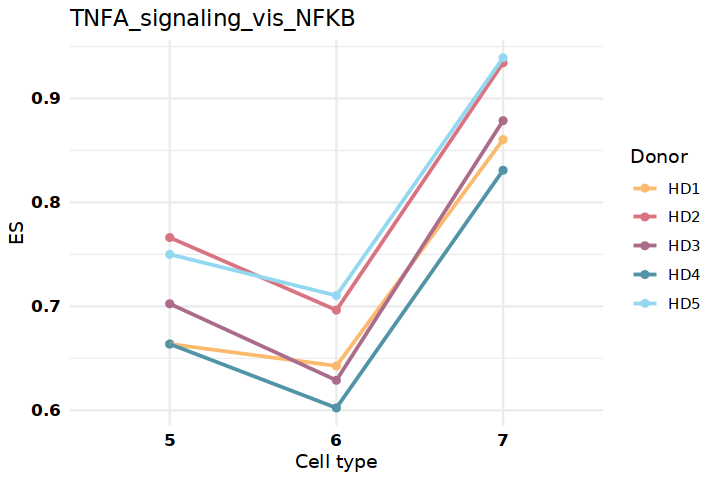

In [18]:
options(repr.plot.width=6, repr.plot.height=4)
fig4c = as.data.frame(fig4c)
fig4c$gene = row.names(fig4c)
fig4cplot = melt(fig4c,id = "gene")
fig4c.es = subset(fig4cplot,gene=="ES")

fig4c.es$cluster_id = sapply(strsplit(as.character(fig4c.es$variable),"-"),"[",1)
fig4c.es$Donor = sapply(strsplit(as.character(fig4c.es$variable),"-"),"[",2)
ggplot(fig4c.es,aes(x = factor(cluster_id),y = value,group = Donor,color = Donor)) + 
  geom_point(size = 1.5,alpha = 1) + scale_color_manual(values= c("#FCBA6E","#D97380","#AB6C8B","#5294A6","#93D8F0"))+
  #facet_wrap(pattern~.,scales = "free_y",ncol = 1) +
  #geom_smooth(method = "loess",span = 1,se = FALSE,size = 0.75,color ="#F57E2C" )+
  #coord_flip()+
  geom_line(size = 0.8)+
  labs(x = "Cell type", y = "ES") +
  theme_minimal()+
  ggtitle("TNFA_signaling_vis_NFKB") +
  theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,colour="black", size = 10,face = "bold"),
       axis.text.y=element_text(colour="black", size = 10,face = "bold"))

### Figure 3C


In [22]:
head(fig4c)

,5-HD1,5-HD2,5-HD3,5-HD4,5-HD5,6-HD1,6-HD2,6-HD3,6-HD4,6-HD5,7-HD1,7-HD2,7-HD3,7-HD4,7-HD5,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
PLEK,0.1062552,0.1793825,0.4655530,0.2267468,0.2982625,0.06637536,0.1276738,0.21639555,0.1125445,0.1825924,0.1513880,0.1997495,0.3618225,0.1597492,0.2632782,PLEK
AREG,0.7041279,0.9941384,0.2470186,0.2980266,0.3156507,0.32832213,0.5717694,0.09737703,0.1141531,0.1988621,0.4335171,0.9547477,0.1687612,0.1777711,0.3570082,AREG
B4GALT1,0.3338236,0.4617935,0.9214103,0.3404084,0.6115525,0.27771520,0.2754840,0.73784000,0.2406551,0.4845509,0.3165453,0.5152390,0.9285309,0.3388616,0.6479694,B4GALT1
SQSTM1,0.5336855,0.5876050,0.6160062,0.5752230,0.7304481,0.59811780,0.6036810,0.71630330,0.6449381,0.7721609,0.6883328,0.7466672,0.8272559,0.8058569,0.9410931,SQSTM1
JUN,2.7444920,2.8710809,2.8770882,3.1711809,3.4151632,2.75977100,2.8044591,2.64431950,3.1012197,3.3941988,3.5324878,3.3651677,3.4371049,3.6954334,3.9299100,JUN
PDE4B,0.6155964,0.5618152,0.5885671,0.3802678,0.4732807,0.56199480,0.4779525,0.56190080,0.2845856,0.4133544,0.7922337,0.8807590,0.8627072,0.5808883,0.7480884,PDE4B


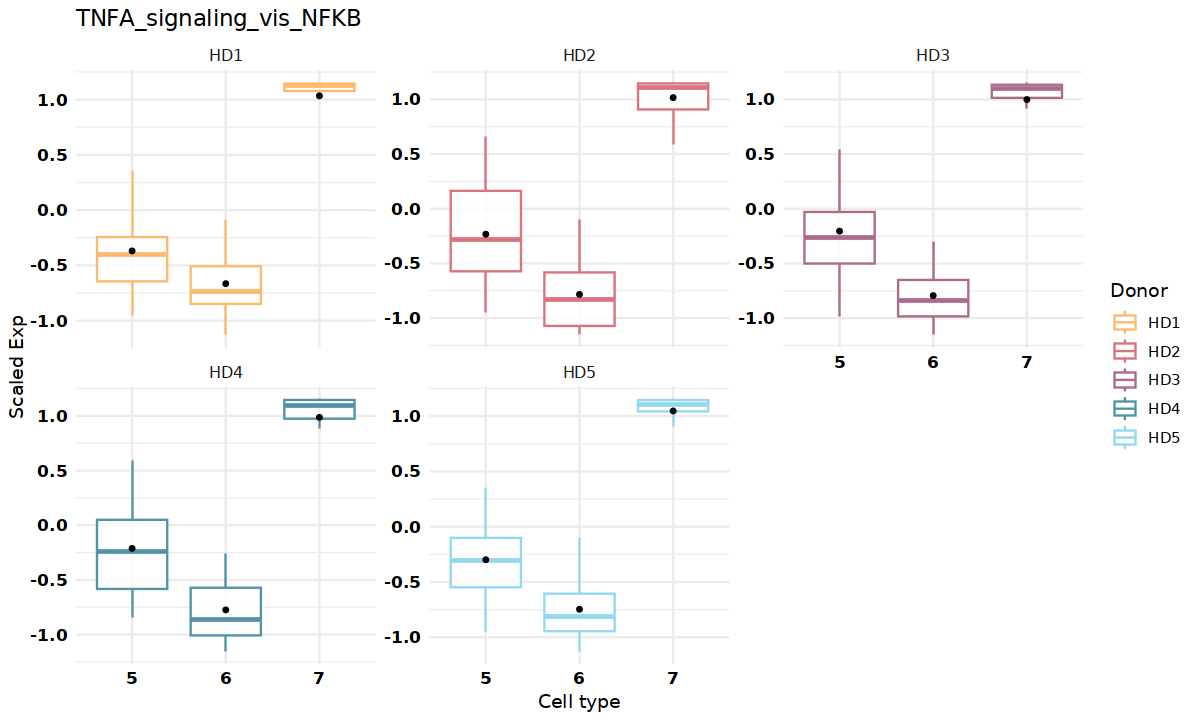

In [21]:
options(repr.plot.width=10, repr.plot.height=6)
## scatterplot using scale value
tnfa.deg1.scl = c()
for(i in 1:5){
  
  temp = fig4c[,grepl(paste0(i,"$"),colnames(fig4c))]
  temp2 = apply(temp,1,scale)
  tnfa.deg1.scl = cbind(tnfa.deg1.scl,t(temp2))
}
colnames(tnfa.deg1.scl) = paste0(rep(c(5:7),5),"-",rep("HD",15),rep(c(1:5),each = 3))
tnfs.scl4plot = melt(tnfa.deg1.scl)
tnfs.scl4plot$cluster_id = sapply(strsplit(as.character(tnfs.scl4plot$Var2),"-"),"[",1)
tnfs.scl4plot$Donor = sapply(strsplit(as.character(tnfs.scl4plot$Var2),"-"),"[",2)
ggplot(tnfs.scl4plot,aes(x = factor(cluster_id),y = value,color  = Donor)) + 
  scale_color_manual(values= c("#FCBA6E","#D97380","#AB6C8B","#5294A6","#93D8F0"))+ #Donor
  #scale_color_manual(values = c("#BCD3DF","#213558", "#32B2BF"))+ # cluster id
  #geom_point(alpha = 0.8)+
  facet_wrap(Donor~.,scales = "free_y",ncol = 3) +
  #geom_line(aes(x = factor(cluster_id),y = value,color = Donor,group = Var1),alpha = 0.8)+
  #geom_smooth(method = "loess",span = 1,se = FALSE,size = 0.75,color ="#F57E2C" )+
  geom_boxplot(alpha = 0.8,outlier.alpha = 0) +
  stat_summary(fun=mean, geom="point", shape=20, size=1.5, color="black", fill="black") +
  labs(x = "Cell type", y = "Scaled Exp") +
  theme_minimal()+
  ggtitle("TNFA_signaling_vis_NFKB") +
  theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,colour="black", size = 10,face = "bold"),
       axis.text.y=element_text(colour="black", size = 10,face = "bold"),
       strip.text.x = element_text(size = 9))

### Figure 3D

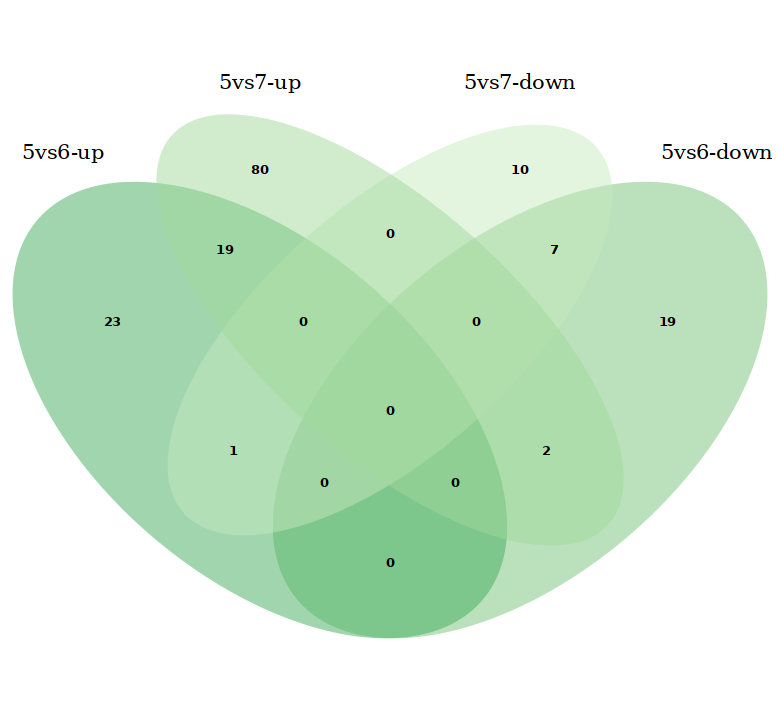

In [27]:
options(repr.plot.width=6.5, repr.plot.height=6)
marker.loc.list = vector("list")
for(i in c("5vs6","5vs7")){
    marker.loc.list[[paste0(i,"-up")]] = row.names(subset(mast.deg[[i]],avg_logFC <= -0.25))
    marker.loc.list[[paste0(i,"-down")]] = row.names(subset(mast.deg[[i]],avg_logFC >= 0.25))
}

# Prepare a palette of 4 colors with R colorbrewer:
myCol <-  c("#41AB5D","#74C476","#A1D99B","#C7E9C0")
#wes_palette("Moonrise3", n = 4)
# Chart
venn.plot <- venn.diagram(
  x = marker.loc.list,
  NULL,
  category.names = names(marker.loc.list),
  
  # Circles
  lwd = 2,
  lty = 'blank',
  fill = myCol,
  
  # Numbers
  cex = .6,
  fontface = "bold",
  fontfamily = "sans"#,
  
  # Set names
  # cat.cex = 0.6,
  # cat.fontface = "bold",
  # cat.default.pos = "outer",
  # cat.pos = c(-27, 27, 135),
  # cat.dist = c(0.055, 0.055, 0.085),
  # cat.fontfamily = "sans",
  # rotation = 1
)


grid.draw(venn.plot)


### Figure 3E

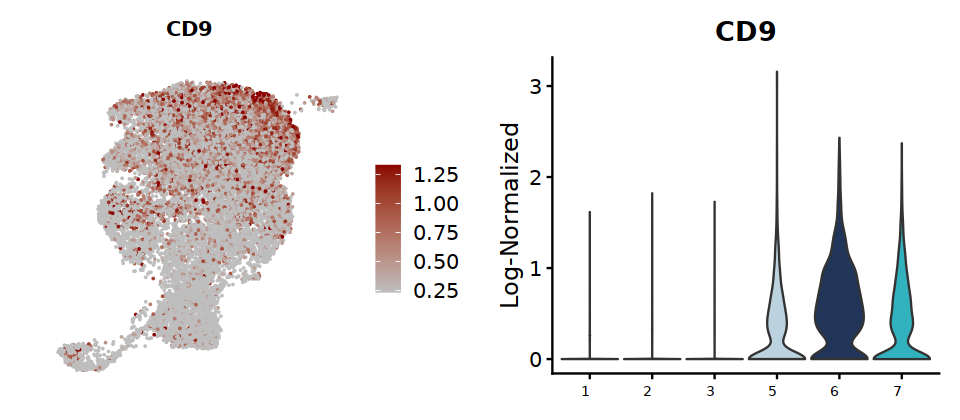

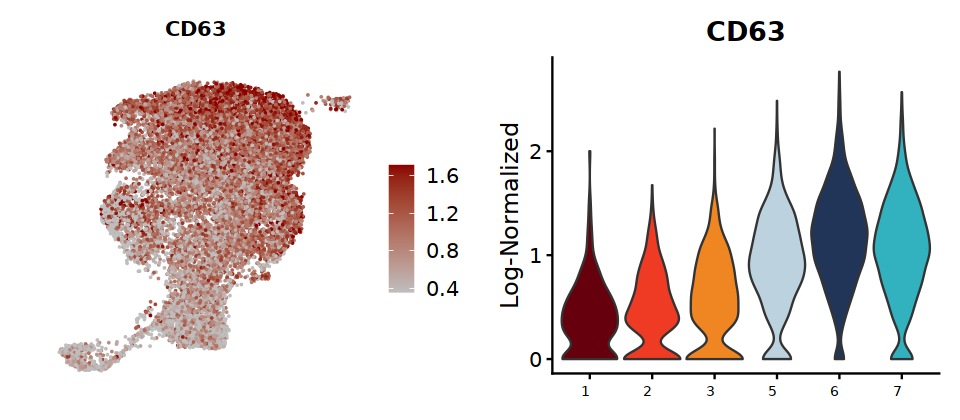

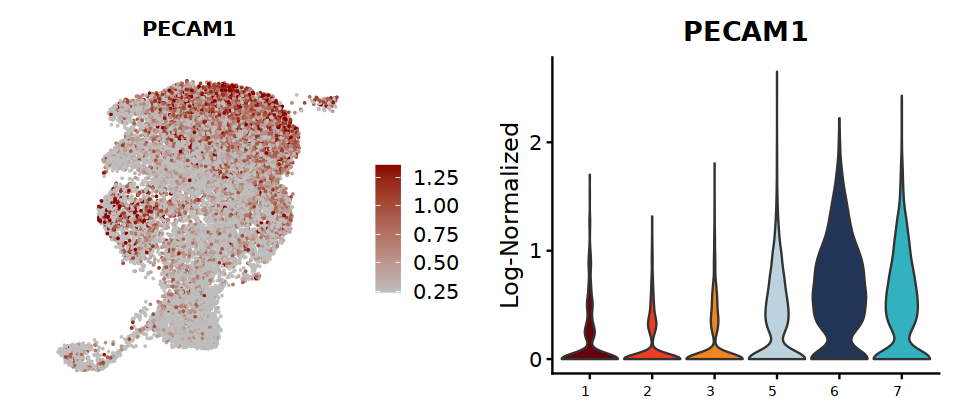

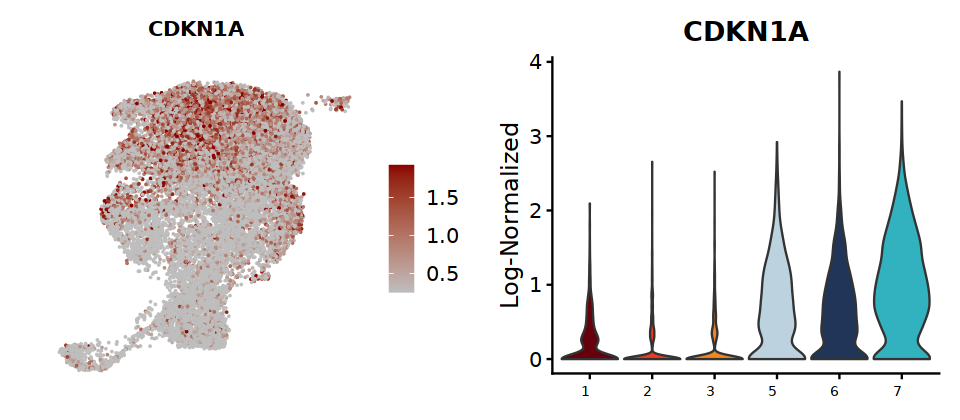

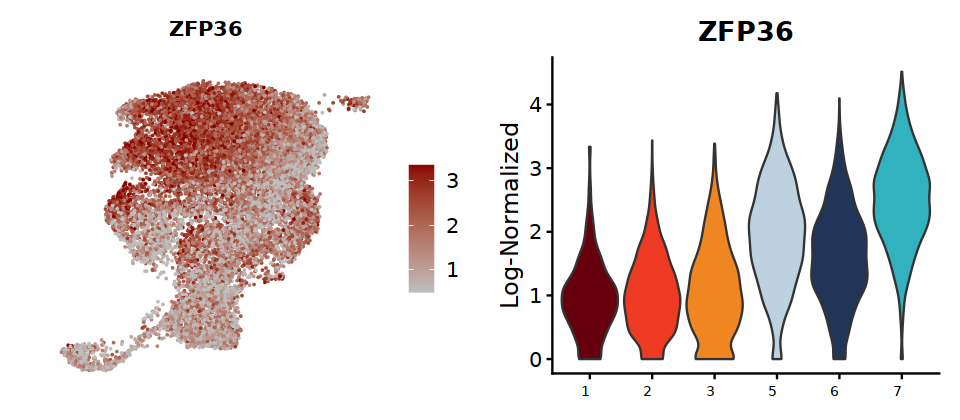

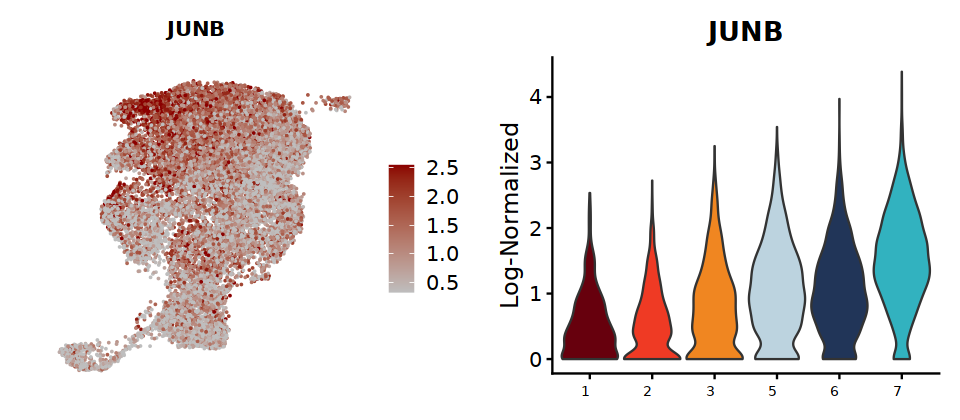

In [32]:
options(repr.plot.width=8, repr.plot.height=3.5)
define_region <- function(row, col){
  viewport(layout.pos.row = row, layout.pos.col = col)
}
pc.fig3 = subset(pc.filt.combined,idents = c(1,2,3,5,6,7))
for(gene in c("CD9","CD63","PECAM1","CDKN1A","ZFP36","JUNB")){
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow = 1, ncol=2)))
    p <- FeaturePlot(object = pc.filt.combined, features = gene,min.cutoff = "q05", max.cutoff = "q95",pt.size = 0.01, col = c("grey","darkred")) + 
    theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),
        axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "right",plot.title = element_text(size=12,face = "bold")) 
    print(p,vp = define_region(row = 1, col = 1))
    
    p <- VlnPlot(pc.fig3,features = gene,group.by = "cluster_id",pt.size = 0,assay = "RNA",ncol = 1,cols = c("#67000D", "#EF3A24", "#F08621", "#BCD3DF", "#213558", "#32B2BF","#5ABC6C","#428C53","#143E2A")) + theme(axis.text.x=element_text(angle = 0,vjust = 0.5,hjust = 1,size = 8),axis.title.x=element_blank(),legend.position = "none")+xlab("")+ylab("Log-Normalized")
    print(p,vp = define_region(row = 1, col = 2))
 
}

### Figure 3F

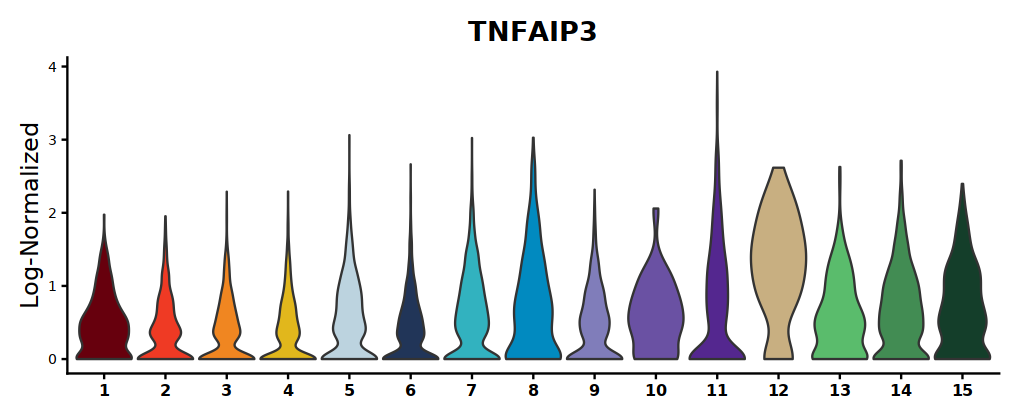

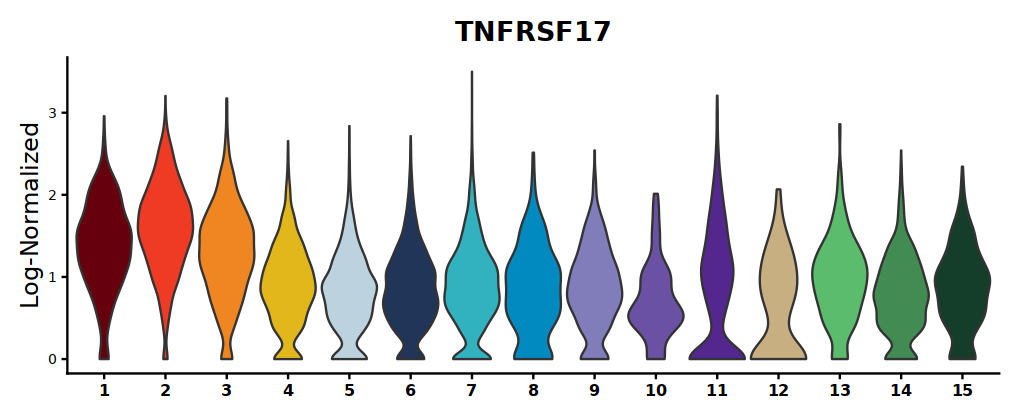

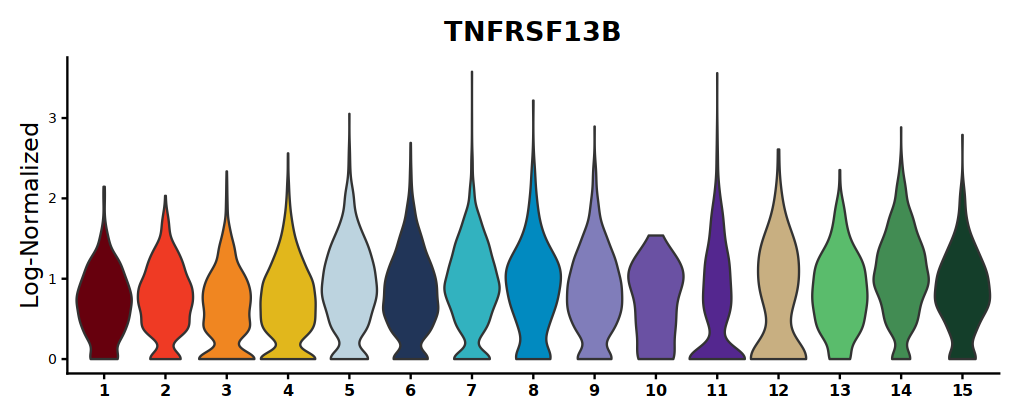

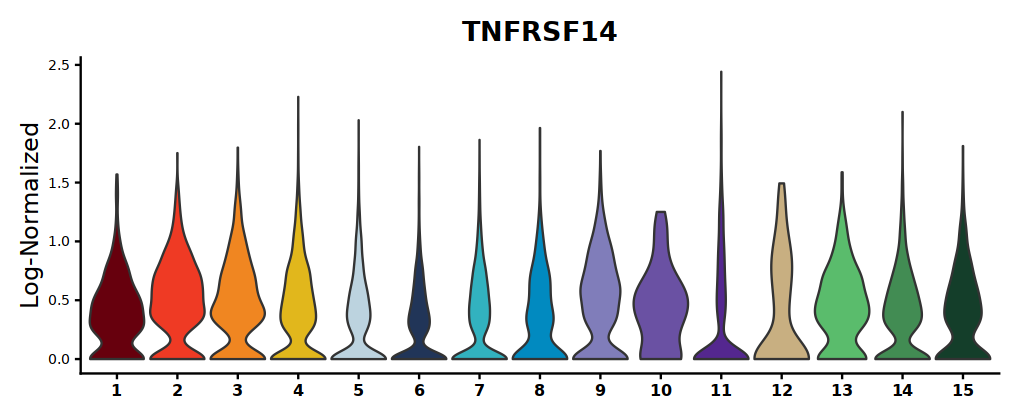

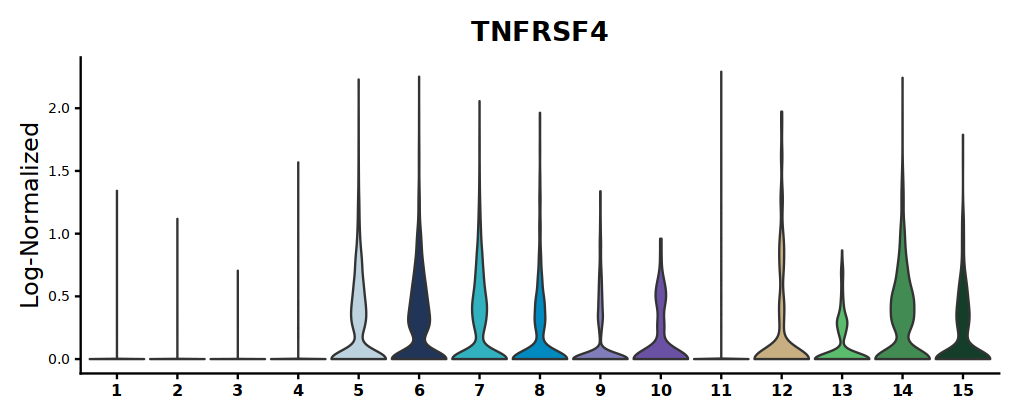

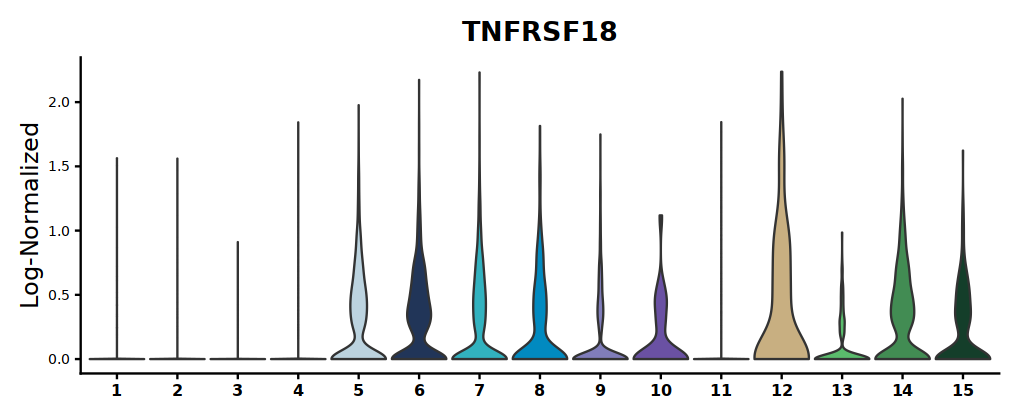

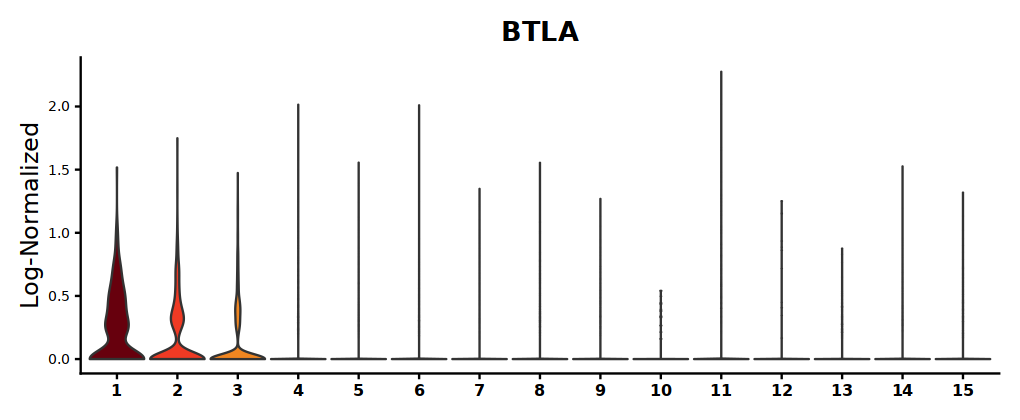

In [35]:
## Violin plots
options(repr.plot.width=8.5, repr.plot.height=3.5)
TNF.select = c("TNFAIP3","TNFRSF17","TNFRSF13B","TNFRSF14","TNFRSF4","TNFRSF18","BTLA")
for(gene in TNF.select){
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow = 1, ncol=1)))
  
    p <- VlnPlot(pc.filt.combined,features = gene,group.by = "cluster_id",pt.size = 0,assay = "RNA",ncol = 1,
                cols = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF",
                         "#213558", "#32B2BF","#018AC0","#807DBA","#6A51A3",
                         "#54278F","#C8AF81","#5ABC6C","#428C53","#143E2A")) + 
    theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,size = 9,face = "bold"),axis.title.x=element_blank(),
          legend.position = "none",axis.text.y=element_text(size = 8))+xlab("")+ylab("Log-Normalized")
    print(p,vp = define_region(row = 1, col = 1))
}

,TNFRSF4,TNFRSF18,cluster_id,TNFRSF4_group,TNFRSF18_group
,<dbl>,<dbl>,<fct>,<chr>,<chr>
CLS028-popA_AAACGGGCACGCCAGT-1,0,0,2,NoExp,NoExp
CLS028-popA_AAACGGGCACTTACGA-1,0,0,3,NoExp,NoExp
CLS028-popA_AAAGATGAGTGATCGG-1,0,0,3,NoExp,NoExp
CLS028-popA_AAAGCAAAGCGTAATA-1,0,0,4,NoExp,NoExp
CLS028-popA_AAAGCAACAAACTGTC-1,0,0,7,NoExp,NoExp
CLS028-popA_AAAGTAGAGTTGAGTA-1,0,0,7,NoExp,NoExp


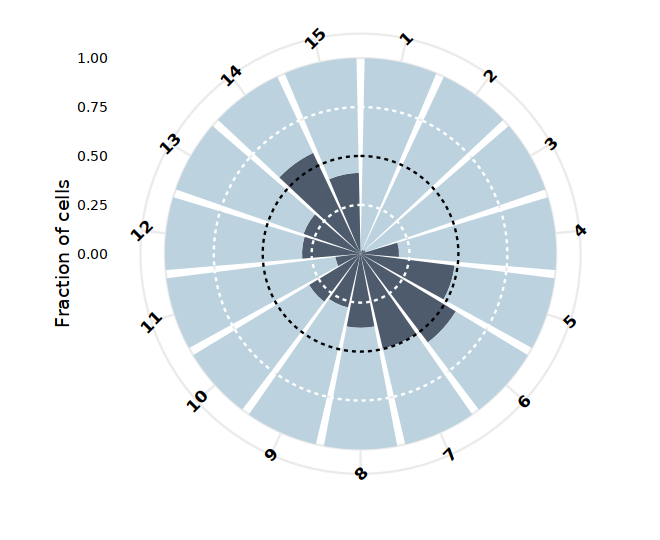

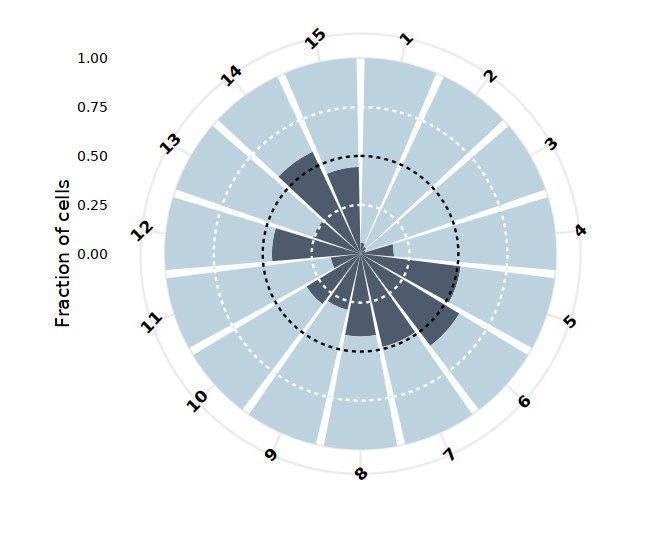

In [46]:
### proportion plot
gene.select = c("TNFRSF4","TNFRSF18")
fig4e = data.frame(t(pc.filt.combined[["RNA"]]@data[gene.select,])) %>% 
mutate(cluster_id = pc.filt.combined$cluster_id) %>%
mutate(TNFRSF4_group = ifelse(TNFRSF4>0,"Exp","NoExp")) %>%
mutate(TNFRSF18_group = ifelse(TNFRSF18>0,"Exp","NoExp"))
head(fig4e)
fig4eplot = melt(fig4e,"cluster_id")

options(repr.plot.width=5.5, repr.plot.height=4.5)
for(i in paste0(gene.select,"_group")){
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow = 1, ncol=1)))
  
    tt = as.data.frame(round(prop.table(x = table(fig4e[,i],fig4e$cluster_id),margin = 2),5))
    names(tt) = c(i,"cell_ident","Freq")

    #tt$cell_ident = factor(tt$cell_ident,levels = c(15:1))
    tt[,i] = factor(tt[,i],levels = c("NoExp","Exp"))
    p <- ggplot(tt,aes(y = Freq, x = factor(cell_ident), fill = get(i))) + geom_bar(stat="identity")+ 
    geom_hline(yintercept = 0.5,colour="#000000", linetype="dashed")+ 
    geom_hline(yintercept = 0.25,colour="#FFFFFF", linetype="dashed") +
    geom_hline(yintercept = 0.75,colour="#FFFFFF", linetype="dashed") +
    coord_polar()+
    scale_fill_manual(values=c("#BCD3DF","#4E5B6D")) + labs(x=" ", y="Fraction of cells") + 
    theme_minimal()+
    theme(axis.text.x=element_text(angle = 45,vjust = 1,hjust = 1,colour="black", size = 10,face = "bold"), 
          axis.text.y=element_text(colour="black", size = 8),legend.position = "none") #+ guides(fill=guide_legend(ncol=2))
    print(p,vp = define_region(row = 1, col = 1))
}